# Module 5 : Relax and Hold Steady - Stokes Flow

### Introduction

#### Vorticité

Nous allons résoudre les équations de l'écoulement de Stokes dans une cavité carrée. Pour ce faire, nous allons utiliser la vorticité. Cela nous permet de simplifier les équations de Navier-Stokes en éliminant la non-linéarité.

On commence avec l'équation de Navier-Stokes pour un écoulement incompressible:

$$\frac{\partial u}{\partial t} + u \cdot \nabla u = -\frac{1}{\rho}\nabla p + \nu\nabla^2 u\ \ \ \ \ (1)$$

Après quelques manipulations mathématiques, on peut exprimer l'équation de transport de la vorticité simplifiée:

$$\begin{equation} \nabla ^2 \omega = 0\ \ \ \ \ (2) \end{equation}$$

#### Fonction de courant

Nous pouvons définir la fonction de courant de cette manière:

$$\begin{equation} u = \frac{\partial \psi}{\partial y} \text{   and   } v = - \frac{\partial \psi}{\partial x}\ \ \ \ \ (3) \end{equation}$$

En 2D, la vorticité peut s'écrire ainsi:

$$\begin{equation} \omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}\ \ \ \ \ (4) \end{equation}$$

En combinant les équations (3) et (4) on obtient:

$$\begin{equation} \nabla^2 \psi = -\omega\ \ \ \ \ (5) \end{equation}$$

Nous avons donc un système de deux équations couplées qui peut décrire l'écoulement d'un fluide dans une cavité avec une paroi coulissante et avec des nombres de Reynolds très petits.

$$\begin{equation} \nabla ^2 \omega = 0\ \ \ \ \ (2) \end{equation}$$
$$\begin{equation} \nabla^2 \psi = -\omega\ \ \ \ \ (5) \end{equation}$$

### Ecoulement dans la cavité

Pour commencer, importons les packages habituels

In [1]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import cm

Nous allons résoudre un problème appelé écoulement dans une cavité avec une paroi coulissante. Prenons la paroi supérieure d'une cavité carrée qui bouge à la vitesse constante u=1

Aucun fluide ne peut passer par les parois et il n'a pas de glissement le long des parois. Nous allons visualiser l'écoulement dans la cavité lorsque l'état stable est atteint. 
Les conditions aux limites sont spécifiées en terme de la fonction de courant Ψ.
#### Figure 1. Lid-driven Cavity Flow
<img src="./drivencavity.svg" width=400px>


#### Valeurs initiales:

In [15]:
nx = 41    # Soit nx le nombre de graduation selon l'axe x
ny = 41    # Soit ny le nombre de graduation selon l'axe y
l = 1.     # La longeur de la boîte
h = 1.     # La hauteur de la boîte
dx = l/(nx-1)    # Soit dx la taille des graduations selon l'axe x
dy = h/(ny-1)    # Soit dy la taille des graduations selon l'axe y
l1_target = 1e-6    # Soit l1_target la précision demandée (différence entre deux Ψ ou ω d'itérations consécutives)
x = numpy.linspace(0,l,nx) # Définition de l'axe x
y = numpy.linspace(0,h,ny) # Définition de l'axe y
psi0 = numpy.zeros((ny,nx)) # Définiton initiale de la matrice Ψ
w0 = numpy.zeros((ny,nx)) # Définition initiale de la matrice ω 
utop = 1   # Vitesse sur la paroi supérieure
uleft = 0  # Vitesses des trois autres parois
uright = 0
ubottom = 0
d = dx     # Comme dx et dy sont identiques, on les appelle par "d" afin de simplifier les calculs

#### Fonction L1norm:

In [16]:
def L1norm(new, old):       # Fonction qui prend deux tableaux, qui somme les valeurs absolues des différences 
    norm = numpy.sum(numpy.abs(new-old)) # entre chaque élément. Cette somme est appelée norm.  
    return norm                          # Elle va nous permettre de savoir quand est ce que la précision 
                                         # de 1E-6 est atteinte.

#### Méthode de Jacobi:
Nous utilisons la méthode d'itération de Jacobi comme donnée dans le notebook, cette méthode remplace notre point la moyenne des quatres points voisins. Pour $\omega$, cela donne simplement:

 $$\begin{equation}
w^{k+1}_{i,j} = \frac{1}{4} \left(w^{k}_{i,j-1} + w^k_{i,j+1} + w^{k}_{i-1,j} + w^k_{i+1,j} \right)
\end{equation}(6)$$ 

Par contre pour $\psi$ il faut rajouter le terme de source (équation $(5)$)

Du coup, cela donne: $$ \psi_{i,j}^{k+1}=\frac{(\psi_{i+1,j}^{k}+\psi_{i-1,j}^{k})\Delta y^2+(\psi_{i,j+1}^{k}+\psi_{i,j-1}^{k})\Delta x^2-w_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}$$

Et comme $\Delta x$ et $\Delta y$ sont égaux, on a la formule simplifiée: $$ \psi_{i,j}^{k+1}=\frac{\psi_{i+1,j}^{k}+\psi_{i-1,j}^{k}+\psi_{i,j+1}^{k}+\psi_{i,j-1}^{k}-w_{i,j}^{k}\Delta^2}{4} \ \ (7)$$


#### Conditions aux bords:
Les conditions aux bords sont définies en terme de $\psi$ et ses dérivées (voir figure 1). 
Mais l'équation de Laplace pour $\omega$ (équation $(2)$) ne prend pas de valeur de $\psi$.

Il faut faire quelques manipulations mathématiques, notamment une discrétisation au troisième ordre de $\frac{\partial \psi}{\partial y}$ évaluée sur le bord supérieur 

\begin{equation}
\left.\frac{\partial \psi}{\partial y}\right|_j = \frac{2\psi_{j+1} + 3\psi_j - 6\psi_{j-1} + \psi_{j-2}}{6 \Delta y}
\end{equation}

Seulement, $\psi_{j+1}$ est hors du domaine, mais comme on sait que  $\left.\frac{\partial \psi}{\partial y}\right|_j = u_j$, on peut l'exprimer avec des points du domaine.

Donc en discrétisant \begin{equation}
\frac{\partial ^2 \psi}{\partial y^2} = -\omega
\end{equation} 
on a \begin{equation}
\omega_j = - \left(\frac{\psi_{j+1} - 2\psi_j + \psi_{j-1}}{\Delta y^2}\right)
\end{equation}

et enfin, en remplaçant $\psi_{j+1}$:

\begin{equation}
\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j-1} - \psi_{i, j-2}) - \frac{3u_j}{\Delta y} + \mathcal{O}(\Delta y^2) \ \ (8)
\end{equation}

On a donc une condition sur le bord supérieur pour $\omega$. Il suffit de faire un développement similaire pour les autres côtés afin de trouver les autres conditions.

#### Coding assignment

In [17]:
def mylaplacepoisson_nest(psi, w, l1_target, ut, ub, ur, ul):  
    # Définition de la fonction nous permettant de trouver ω et Ψ après relaxation dans la cavité.
    # Les u sont les vitesses des différents bords, dans cet exercice, utop est fixée à 1 
    # tandis que les autres sont à 0.
            
    
    iterations = 0        #Initialisation du nombre d'iterations de la fonction
    normw = l1_target+1   #Initialisation de normw pour qu'il soit plus grand que l1_target
    normpsi = l1_target+1 #Initialisation de normpsi pour qu'il soit plus grand que l1_target
   
    while (normw > l1_target or normpsi > l1_target): # Définition de la boucle pour avoir la précision recherchée 
        
        w_n = w.copy()           #Nous utilisons w_n et psi_n pour sauvegarder les valeurs de l'itération précédente
        psi_n = psi.copy()
        
        # Appliquons la méthode d'itérations de Jacobi pour trouver ω (équation (6))
        
        w[1:-1,1:-1] = .25 * (w_n[1:-1,:-2] + w_n[1:-1,2:] + w_n[:-2,1:-1] + w_n[2:,1:-1])
        
        #Boundary conditions avec l'équation (8) 
        
        w[0,:] = ((-1/(2*d**2)) * (8*psi[1,:] - psi[2,:] )) + 3*ub/d    # bord inférieur
        w[-1,:] = ((-1/(2*d**2)) * (8*psi[-2,:] - psi[-3,:] )) - 3*ut/d    # bord supérieur
        w[:,0] = ((-1/(2*d**2)) * (8*psi[:,1] - psi[:,2] )) + 3*ul/d      # bord gauche 
        w[:,-1] = ((-1/(2*d**2)) * (8*psi[:,-2] - psi[:,-3] )) - 3*ur/d  # bord droit
        
        # Appliquons maintenant Jacobi à ψ avec les valeurs trouvées pour ω (équation (7))
        
        psi[1:-1,1:-1] = .25 * ((psi_n[1:-1,2:] + psi_n[1:-1,:-2] +\
                        psi_n[2:,1:-1] + psi_n[:-2,1:-1]) + w[1:-1,1:-1]*d**2)
       
        
        normw =  L1norm(w_n, w)      # Comparaison des normes de w et w_n grâce à la fonction L1norm
        normpsi = L1norm(psi_n, psi) # Comparaison des normes de psi et psi_n grâce à la fonction L1norm
        
        iterations += 1 # Nous comptons les itérations
        
    return psi, w, iterations, normw, normpsi

Remarquons que nous avons appliquer en premier lieu les conditions sur le haut ainsi que sur le bas de la boîte, et ensuite les conditions sur les deux autres côtés. Ce choix, à priori abitraire, a une influence sur les données dans les coins de notre cavité. C'est cet ordre là qui nous rend les réponses validées par numerical mooc.

Nous appliquons notre fonction mylaplacepoisson_nest à nos valeurs initiales.

In [18]:
psi, w, iterations, normw, normpsi = mylaplacepoisson_nest(psi0, w0, l1_target, utop, ubottom, uright, uleft)

Nous regardons le nombre d'itérations et vérifions les normes de $\psi$ et $\omega$

In [19]:
print(iterations, normw, normpsi)

4060 9.99748579551e-07 2.22733131185e-08


#### Graphique de $\psi$

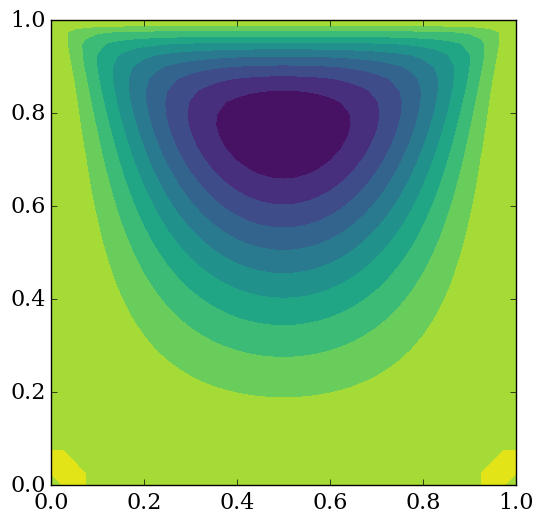

In [20]:
pyplot.figure(figsize=(6,6))
pyplot.contourf(x,y,psi,10,cmap=cm.viridis)

Nous avons bien le même graphique que dans le notebook, ce qui est assez satisfaisant.

#### Graphique de $\omega$

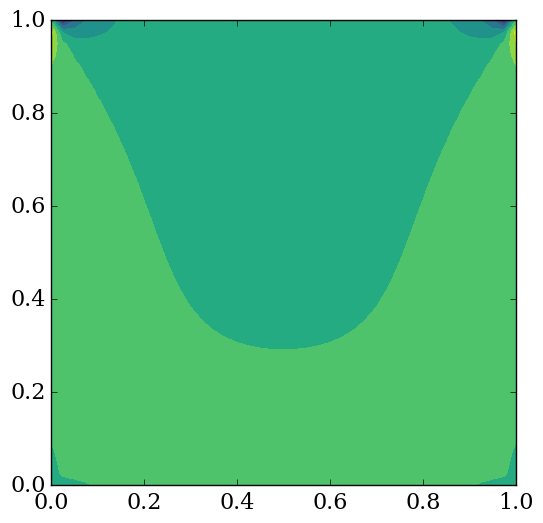

In [21]:
pyplot.figure(figsize=(6,6))
pyplot.contourf(x,y,w,10,cmap=cm.viridis)

### Question 1

Quelles sont les valeurs maximales de |$\omega$| et |$\psi$| dans la cavité?

Nous donnons deux réponses: La première prend les bords de la cavité en compte, la deuxième les exclut.

In [22]:
print ("La valeur maximale de |Ψ| dans la cavité est",numpy.max(numpy.abs(psi[:])))
print ("La valeur maximale de |Ψ| à l'intérieur de la cavité (en excluant les bords) est",(numpy.max(numpy.abs(psi[1:-1,1:-1]))))

La valeur maximale de |Ψ| dans la cavité est 0.0998451724383
La valeur maximale de |Ψ| à l'intérieur de la cavité (en excluant les bords) est 0.0998451724383


In [23]:
print ("La valeur maximale de |w| dans la cavité est",numpy.max(numpy.abs(w[:])))
print ("La valeur maximale de |w| à l'intérieur de la cavité (en excluant les bords) est",(numpy.max(numpy.abs(w[1:-1,1:-1]))))

La valeur maximale de |w| dans la cavité est 78.1926612286
La valeur maximale de |w| à l'intérieur de la cavité (en excluant les bords) est 22.5607771651


### Question 2

Quels sont les 6 nombres rendu par numpy.round(psi[32,::8], 4)?

In [24]:
numpy.round(psi[32,::8], 4)

array([ 0.    , -0.0575, -0.0944, -0.0944, -0.0575,  0.    ])

## Pour aller plus loin

Nous allons utiliser notre code pour des valeurs différentes de u sur les bords.

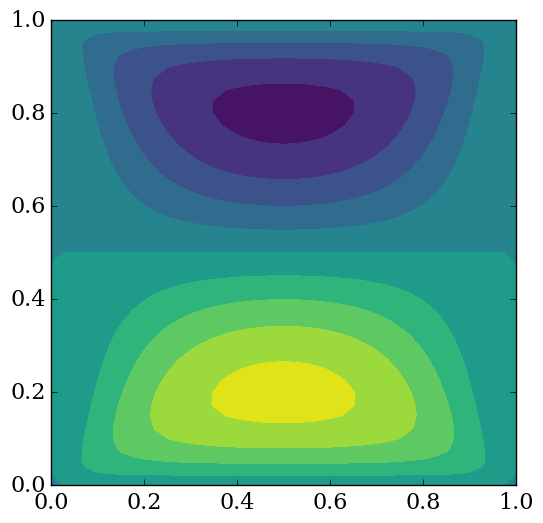

In [25]:
ut2 = 1   
ul2 = 0  
ur2 = 0
ub2 = 1
psi2, w2, iterations, normw2, normpsi2 = mylaplacepoisson_nest(psi0, w0, l1_target, ut2, ub2, ur2, ul2)
pyplot.figure(figsize=(6,6))
pyplot.contourf(x,y,psi2,10,cmap=cm.viridis)

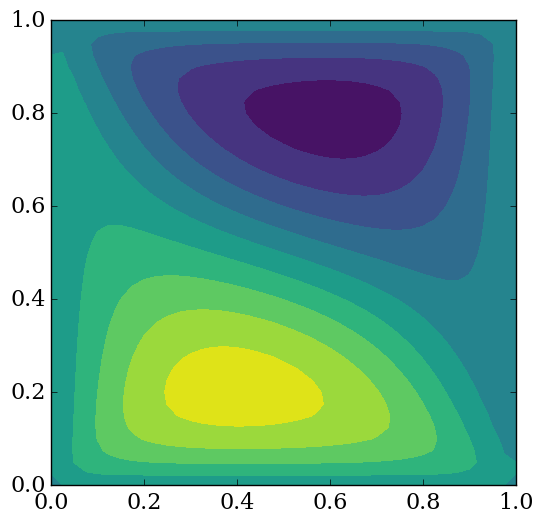

In [29]:
ut3 = 3   
ul3 = 1  
ur3 = 1
ub3 = 3
psi3, w3, iterations, normw3, normpsi3 = mylaplacepoisson_nest(psi0, w0, l1_target, ut3, ub3, ur3, ul3)
pyplot.figure(figsize=(6,6))
pyplot.contourf(x,y,psi2,10,cmap=cm.viridis)

## Conclusion

Nous avons utlisé la méthode d'itération de Jacobi pour trouver vers quel état d'équilibre le fluide évolue, sachant les conditions initiales imposées. Nous avons ensuite trouvé les valeurs maximales de |Ψ| et |w| dans la cavité. 